In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 5.0 MB/s 
     |████████████████████████████████| 189 kB 55.3 MB/s 
     |████████████████████████████████| 46 kB 1.6 MB/s 
     |████████████████████████████████| 1.2 MB 39.0 MB/s 
     |████████████████████████████████| 56 kB 1.6 MB/s 
     |████████████████████████████████| 51 kB 96 kB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastai.vision.all import *
from fastbook import *

matplotlib.rc('image', cmap='Greys')

# Under the Hood: Training a Digit Classifier

## Pixels: The Foundations of Computer Vision

## Sidebar: Tenacity and Deep Learning

## End sidebar

In [3]:
path = untar_data(URLs.MNIST_SAMPLE)

In [4]:
#hide
Path.BASE_PATH = path

In [5]:
path.ls()

(#3) [Path('valid'),Path('labels.csv'),Path('train')]

In [6]:
# path.ls?

In [7]:
# path.ls??

In [8]:
doc(path.ls)

In [9]:
(path/'train').ls()

(#2) [Path('train/7'),Path('train/3')]

In [10]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png')...]

In [11]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [12]:
array(im3)[4:10,4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [13]:
tensor(im3)[4:10,4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

In [14]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[4:15,4:22])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0
2,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0
3,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0
4,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0
5,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0
6,0,0,0,0,0,0,0,0,0,0,249,253,245,126,0,0,0,0
7,0,0,0,0,0,0,0,14,101,223,253,248,124,0,0,0,0,0
8,0,0,0,0,0,11,166,239,253,253,253,187,30,0,0,0,0,0
9,0,0,0,0,0,16,248,250,253,253,253,253,232,213,111,2,0,0


## First Try: Pixel Similarity

In [18]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]
three_tensors = [tensor(Image.open(o)) for o in threes]
len(three_tensors),len(seven_tensors)

(6131, 6265)

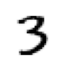

In [19]:
show_image(three_tensors[1]);

In [21]:
three_tensors[1].shape

torch.Size([28, 28])

In [22]:
type(three_tensors)

list

In [20]:
stacked_sevens = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [23]:
len(stacked_threes.shape)

3

In [24]:
stacked_threes.ndim

3

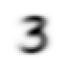

In [25]:
mean3 = stacked_threes.mean(0)
show_image(mean3);

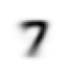

In [26]:
mean7 = stacked_sevens.mean(0)
show_image(mean7);

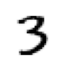

In [27]:
a_3 = stacked_threes[1]
show_image(a_3);

In [28]:
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()
dist_3_abs,dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [29]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [30]:
F.l1_loss(a_3.float(),mean7), F.mse_loss(a_3,mean7).sqrt()

(tensor(0.1586), tensor(0.3021))

### NumPy Arrays and PyTorch Tensors

In [31]:
data = [[1,2,3],[4,5,6]]
arr = array (data)
tns = tensor(data)

In [32]:
arr  # numpy

array([[1, 2, 3],
       [4, 5, 6]])

In [33]:
tns  # pytorch

tensor([[1, 2, 3],
        [4, 5, 6]])

In [34]:
tns[1]

tensor([4, 5, 6])

In [36]:
# don't need colons at end indices but good to be explicit
tns[1,:]

tensor([4, 5, 6])

In [35]:
tns[:,1]

tensor([2, 5])

In [37]:
tns[1,1:3]

tensor([5, 6])

In [38]:
tns+1

tensor([[2, 3, 4],
        [5, 6, 7]])

In [39]:
tns.type()

'torch.LongTensor'

In [40]:
tns*1.5

tensor([[1.5000, 3.0000, 4.5000],
        [6.0000, 7.5000, 9.0000]])

## Computing Metrics Using Broadcasting

In [43]:
valid_3_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'3').ls()])
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = torch.stack([tensor(Image.open(o)) 
                            for o in (path/'valid'/'7').ls()])
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape

(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [44]:
def mnist_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_distance(a_3, mean3)

tensor(0.1114)

In [45]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)
valid_3_dist, valid_3_dist.shape

(tensor([0.1170, 0.1240, 0.1133,  ..., 0.1325, 0.1252, 0.1162]),
 torch.Size([1010]))

In [46]:
tensor([1,2,3]) + tensor([1,1,1])

tensor([2, 3, 4])

In [47]:
(valid_3_tens-mean3).shape

torch.Size([1010, 28, 28])

In [48]:
def is_3(x): return mnist_distance(x,mean3) < mnist_distance(x,mean7)

In [49]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [50]:
is_3(valid_3_tens)

tensor([True, True, True,  ..., True, True, True])

In [51]:
accuracy_3s =      is_3(valid_3_tens).float() .mean()
accuracy_7s = (1 - is_3(valid_7_tens).float()).mean()

accuracy_3s,accuracy_7s,(accuracy_3s+accuracy_7s)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## Stochastic Gradient Descent (SGD)

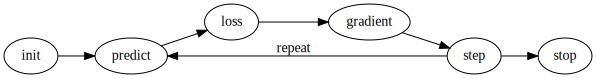

In [202]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

In [203]:
def f(x): return x**2

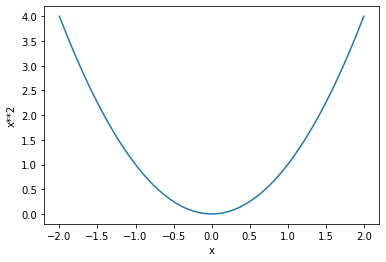

In [204]:
plot_function(f, 'x', 'x**2')

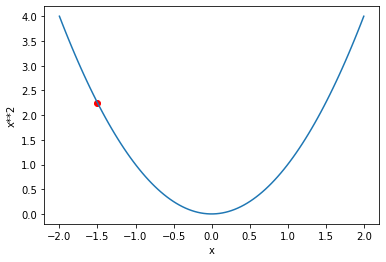

In [205]:
plot_function(f, 'x', 'x**2')
plt.scatter(-1.5, f(-1.5), color='red');

### Calculating Gradients

In [206]:
xt = tensor(3.).requires_grad_()

In [207]:
yt = f(xt)
yt

tensor(9., grad_fn=<PowBackward0>)

In [208]:
yt.backward()

In [209]:
xt.grad

tensor(6.)

In [210]:
xt = tensor([3.,4.,10.]).requires_grad_()
xt

tensor([ 3.,  4., 10.], requires_grad=True)

In [211]:
def f(x): return (x**2).sum()

yt = f(xt)
yt

tensor(125., grad_fn=<SumBackward0>)

In [212]:
yt.backward()
xt.grad

tensor([ 6.,  8., 20.])

### Stepping With a Learning Rate

### An End-to-End SGD Example

In [278]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14., 15., 16., 17., 18., 19.])

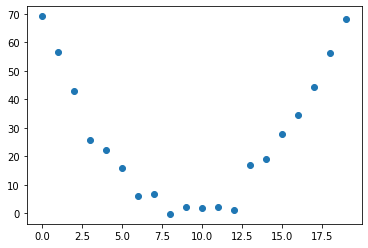

In [279]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1
plt.scatter(time,speed);

In [280]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c

In [281]:
def mse(preds, targets): return ((preds-targets)**2).mean().sqrt()

#### Step 1: Initialize the parameters

In [282]:
params = torch.randn(3).requires_grad_()

In [283]:
#hide
orig_params = params.clone()

#### Step 2: Calculate the predictions

In [284]:
preds = f(time, params)

In [285]:
def show_preds(preds, ax=None):
    if ax is None: ax=plt.subplots()[1]
    ax.scatter(time, speed)
    ax.scatter(time, to_np(preds), color='red')
    ax.set_ylim(-300,100)

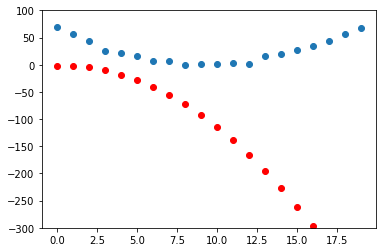

In [286]:
show_preds(preds)

#### Step 3: Calculate the loss

In [287]:
loss = mse(preds, speed)
loss

tensor(220.0296, grad_fn=<SqrtBackward0>)

#### Step 4: Calculate the gradients

In [288]:
loss.backward()
params.grad

tensor([-166.6039,  -10.6648,   -0.7685])

In [289]:
params.grad * 1e-5

tensor([-1.6660e-03, -1.0665e-04, -7.6849e-06])

In [290]:
params

tensor([-1.1929,  0.5960, -1.4723], requires_grad=True)

#### Step 5: Step the weights. 

In [291]:
lr = 1e-3
params.data -= lr * params.grad.data
params.grad = None

In [292]:
preds = f(time,params)
mse(preds, speed)

tensor(192.1859, grad_fn=<SqrtBackward0>)

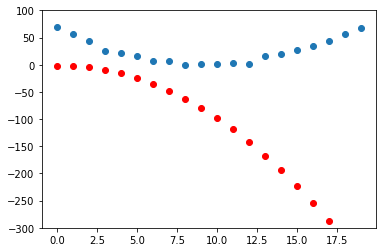

In [293]:
show_preds(preds)

In [294]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds

#### Step 6: Repeat the process 

In [295]:
for i in range(10): apply_step(params)

192.18592834472656
164.4742431640625
136.9701385498047
109.81855773925781
83.3323745727539
58.303955078125
37.142452239990234
26.278411865234375
25.473228454589844
25.468502044677734


In [296]:
#hide
params = orig_params.detach().requires_grad_()

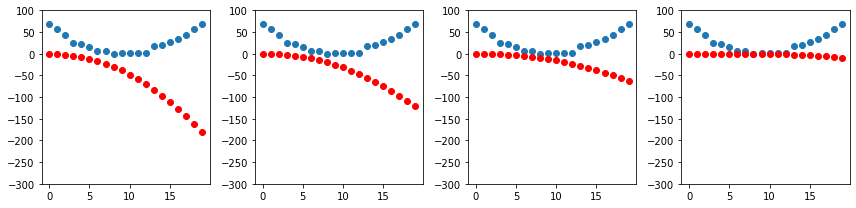

In [298]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

#### Step 7: stop

### Summarizing Gradient Descent

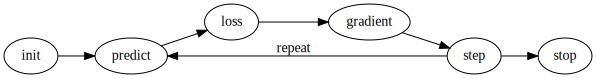

In [233]:
gv('''
init->predict->loss->gradient->step->stop
step->predict[label=repeat]
''')

## The MNIST Loss Function

In [ ]:
train_x = torch.cat([stacked_threes, stacked_sevens]).view(-1, 28*28)

In [ ]:
train_y = tensor([1]*len(threes) + [0]*len(sevens)).unsqueeze(1)
train_x.shape,train_y.shape

In [ ]:
dset = list(zip(train_x,train_y))
x,y = dset[0]
x.shape,y

In [ ]:
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)
valid_y = tensor([1]*len(valid_3_tens) + [0]*len(valid_7_tens)).unsqueeze(1)
valid_dset = list(zip(valid_x,valid_y))

In [ ]:
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

In [ ]:
weights = init_params((28*28,1))

In [ ]:
bias = init_params(1)

In [ ]:
(train_x[0]*weights.T).sum() + bias

In [ ]:
def linear1(xb): return xb@weights + bias
preds = linear1(train_x)
preds

In [ ]:
corrects = (preds>0.0).float() == train_y
corrects

In [ ]:
corrects.float().mean().item()

In [ ]:
weights[0] *= 1.0001

In [ ]:
preds = linear1(train_x)
((preds>0.0).float() == train_y).float().mean().item()

In [ ]:
trgts  = tensor([1,0,1])
prds   = tensor([0.9, 0.4, 0.2])

In [ ]:
def mnist_loss(predictions, targets):
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [ ]:
torch.where(trgts==1, 1-prds, prds)

In [ ]:
mnist_loss(prds,trgts)

In [ ]:
mnist_loss(tensor([0.9, 0.4, 0.8]),trgts)

### Sigmoid

In [ ]:
def sigmoid(x): return 1/(1+torch.exp(-x))

In [ ]:
plot_function(torch.sigmoid, title='Sigmoid', min=-4, max=4)

In [ ]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets==1, 1-predictions, predictions).mean()

### SGD and Mini-Batches

In [ ]:
coll = range(15)
dl = DataLoader(coll, batch_size=5, shuffle=True)
list(dl)

In [ ]:
ds = L(enumerate(string.ascii_lowercase))
ds

In [ ]:
dl = DataLoader(ds, batch_size=6, shuffle=True)
list(dl)

## Putting It All Together

In [ ]:
weights = init_params((28*28,1))
bias = init_params(1)

In [ ]:
dl = DataLoader(dset, batch_size=256)
xb,yb = first(dl)
xb.shape,yb.shape

In [ ]:
valid_dl = DataLoader(valid_dset, batch_size=256)

In [ ]:
batch = train_x[:4]
batch.shape

In [ ]:
preds = linear1(batch)
preds

In [ ]:
loss = mnist_loss(preds, train_y[:4])
loss

In [ ]:
loss.backward()
weights.grad.shape,weights.grad.mean(),bias.grad

In [ ]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
calc_grad(batch, train_y[:4], linear1)
weights.grad.mean(),bias.grad

In [ ]:
weights.grad.zero_()
bias.grad.zero_();

In [ ]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

In [ ]:
(preds>0.0).float() == train_y[:4]

In [ ]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds>0.5) == yb
    return correct.float().mean()

In [ ]:
batch_accuracy(linear1(batch), train_y[:4])

In [ ]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [ ]:
validate_epoch(linear1)

In [ ]:
lr = 1.
params = weights,bias
train_epoch(linear1, lr, params)
validate_epoch(linear1)

In [ ]:
for i in range(20):
    train_epoch(linear1, lr, params)
    print(validate_epoch(linear1), end=' ')

### Creating an Optimizer

In [ ]:
linear_model = nn.Linear(28*28,1)

In [ ]:
w,b = linear_model.parameters()
w.shape,b.shape

In [ ]:
class BasicOptim:
    def __init__(self,params,lr): self.params,self.lr = list(params),lr

    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data * self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [ ]:
opt = BasicOptim(linear_model.parameters(), lr)

In [ ]:
def train_epoch(model):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [ ]:
validate_epoch(linear_model)

In [ ]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end=' ')

In [ ]:
train_model(linear_model, 20)

In [ ]:
linear_model = nn.Linear(28*28,1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

In [ ]:
dls = DataLoaders(dl, valid_dl)

In [ ]:
learn = Learner(dls, nn.Linear(28*28,1), opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(10, lr=lr)

## Adding a Nonlinearity

In [ ]:
def simple_net(xb): 
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [ ]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [ ]:
plot_function(F.relu)

In [ ]:
simple_net = nn.Sequential(
    nn.Linear(28*28,30),
    nn.ReLU(),
    nn.Linear(30,1)
)

In [ ]:
learn = Learner(dls, simple_net, opt_func=SGD,
                loss_func=mnist_loss, metrics=batch_accuracy)

In [ ]:
learn.fit(40, 0.1)

In [ ]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [ ]:
learn.recorder.values[-1][2]

### Going Deeper

In [ ]:
dls = ImageDataLoaders.from_folder(path)
learn = cnn_learner(dls, resnet18, pretrained=False,
                    loss_func=F.cross_entropy, metrics=accuracy)
learn.fit_one_cycle(1, 0.1)

## Jargon Recap

## Questionnaire

1. How is a grayscale image represented on a computer? How about a color image?

  A grayscale image is represented as a 2D array of numbers (typically unsigned integers)

1. How are the files and folders in the `MNIST_SAMPLE` dataset structured? Why?
  - first level: valid, train
  - second level: 3, 7

  Split into validation and training sets then split by digit for easy label extraction for classification.  Only 2 digits, that should be difficult to confuse, to

1. Explain how the "pixel similarity" approach to classifying digits works.

  - take all examples of each individual digit and create an average image providing the average pixel intensity at each location across all examples of that digit.  Then check to see how similar a new image is to each average image digit to figure out what digit is most likely represented.

1. What is a list comprehension? Create one now that selects odd numbers from a list and doubles them.

  List comprehension allows you to go through every item in a list, optionally perform some logic/operations based on this list item, and generate a list from the results of those operations.

In [15]:
# Generate random list of integers
import random
randomlist = [random.randint(1,30) for o in range(50)]
print(randomlist)

[21, 4, 1, 24, 9, 8, 8, 5, 24, 4, 22, 24, 29, 18, 3, 19, 14, 2, 1, 3, 7, 8, 17, 20, 1, 18, 7, 23, 21, 23, 18, 14, 8, 15, 19, 9, 26, 28, 1, 25, 26, 6, 23, 14, 11, 9, 5, 7, 25, 11]


In [17]:
# Perform list comprehension to extracts odds and doubles them
doubleodd = [2*o for o in randomlist if o%2 == 1]
print(doubleodd)

[42, 2, 18, 10, 58, 6, 38, 2, 6, 14, 34, 2, 14, 46, 42, 46, 30, 38, 18, 2, 50, 46, 22, 18, 10, 14, 50, 22]


5. What is a "rank-3 tensor"?

  Basically the pytorch version of a numpy array with extra functionality (including running on GPU as well as CPU) is a tensor.  A rank-3 tensor is a three-dimensional tensor.

1. What is the difference between tensor rank and shape? How do you get the rank from the shape?

  Rank is a measure of dimensionality where shape tells you the length of each axis.

  You can get the shape as follows:

  `tensor_variable.shape`

  You can get the rank as follows:

  `len(tensor_variable.shape)`

  or
  
  `stacked_threes.ndim`

1. What are RMSE and L1 norm?

  - Mean absolute difference (L1 norm)

  $\text{mean absolute difference} = \frac{1}{n} \left| \sum_{i=1}^n (a_i - \hat{a_i}) \right|$

  Where $a_i$ and $\hat{a_i}$ are the same pixels in the images being compared.

  `(a_3 - mean3).abs().mean()`

  - Root Mean Squared Error (RMSE) (L2 norm)

  $\text{RMSE} = \sqrt{ \frac{1}{n} \sum_{i=1}^n (a_i - \hat{a_i})^2}$

  `dist_3_sqr = ((a_3 - mean3)**2).mean().sqrt()`

1. How can you apply a calculation on thousands of numbers at once, many thousands of times faster than a Python loop?

  Broadcasting (see Q. 10).
  
1. Create a 3×3 tensor or array containing the numbers from 1 to 9. Double it. Select the bottom-right four numbers.

In [42]:
data = [[1,2,3],[4,5,6],[7,8,9]]
tns = tensor(data)
tns *= 2
tns[1:3,1:3]

tensor([[10, 12],
        [16, 18]])

10. What is broadcasting?

  Broadcasting is a feature where pytorch will automatically expand the tensor with the smaller rank to have the same size as the one with the larger rank making things like operations on images and batches of images be able to use the same code.  This doesn't use any additional memory in the expansion of the smaller rank tensor (it just knows to reuse those values).  The whole calculation is done in C (or CUDA if running on a GPU) running tens of thousands of times faster than pure Python (up to millions of times faster on a GPU)!

1. Are metrics generally calculated using the training set, or the validation set? Why?

  validation set

1. What is SGD?

  SGD is Stochastic Gradient Descent

  Gradient Descent: Start with some model with weights.  When running an input we generate a loss at the output.  For every weight we can calculate the gradient and adjust the weight in a small step in the direction that decreases our loss.

1. Why does SGD use mini-batches?
1. What are the seven steps in SGD for machine learning?

  From fast.ai:
  - *Initialize* the weights
  - For each image, use these weights to *predict* whether it appears to be a three or seven
  - Based on these predictions, calculate how good the model is (its *loss*)
  - Calculate the *gradient*, which measures for each weight, how changing the weight would change the loss
  - *Step* (that is, change) all weights based on that calculation
  - Go back to the second step, and *repeat* the process
  - ... until you decide to *stop* the training process (for instance because the model is good enough, or you don't want to wait any longer)

```
             ┌►loss ──► gradient──┐
             │                    │
             │                    ▼
init──►predict◄──────────────────step──►stop

                     repeat
```

15. How do we initialize the weights in a model?

  Typically randomly.

1. What is "loss"?

  It's a type of metric used for training purposes instead of necessarily being optimized for the end needs of the resulting system.  The loss should be positive with small values if the result is closer to ideal and larger the further away it is from the right answer.

1. Why can't we always use a high learning rate?

  It may overshoot the local minima and never converge.  Loss will increase as a result over multiple iterations.

1. What is a "gradient"?

  It's a derivative at a point.

1. Do you need to know how to calculate gradients yourself?

  No.  You can mark a tensor to tell pytorch to keep gradient information.

  `a = tensor([3.,4.,10.]).requires_grad_()`

  Perform some function / operations on the variable

  `b = f(a)`

  Tell pytorch to calculate gradients.

  `b.backward()`

  And extract the gradient for the variable of interest

  `a.grad()`

1. Why can't we use accuracy as a loss function?

  We often need the loss function to be more sensitive to subtle weight changes than our evaluation metric.  Shouldn't have a gradient of 0 (say when weights change but not enough to change the classification of the item).

1. Draw the sigmoid function. What is special about its shape?
1. What is the difference between a loss function and a metric?
1. What is the function to calculate new weights using a learning rate?
1. What does the `DataLoader` class do?
1. Write pseudocode showing the basic steps taken in each epoch for SGD.
1. Create a function that, if passed two arguments `[1,2,3,4]` and `'abcd'`, returns `[(1, 'a'), (2, 'b'), (3, 'c'), (4, 'd')]`. What is special about that output data structure?
1. What does `view` do in PyTorch?
1. What are the "bias" parameters in a neural network? Why do we need them?
1. What does the `@` operator do in Python?
1. What does the `backward` method do?
1. Why do we have to zero the gradients?
1. What information do we have to pass to `Learner`?
1. Show Python or pseudocode for the basic steps of a training loop.
1. What is "ReLU"? Draw a plot of it for values from `-2` to `+2`.
1. What is an "activation function"?
1. What's the difference between `F.relu` and `nn.ReLU`?
1. The universal approximation theorem shows that any function can be approximated as closely as needed using just one nonlinearity. So why do we normally use more?

### Further Research

1. Create your own implementation of `Learner` from scratch, based on the training loop shown in this chapter.
1. Complete all the steps in this chapter using the full MNIST datasets (that is, for all digits, not just 3s and 7s). This is a significant project and will take you quite a bit of time to complete! You'll need to do some of your own research to figure out how to overcome some obstacles you'll meet on the way.